In [1]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gzip
import shutil
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
    

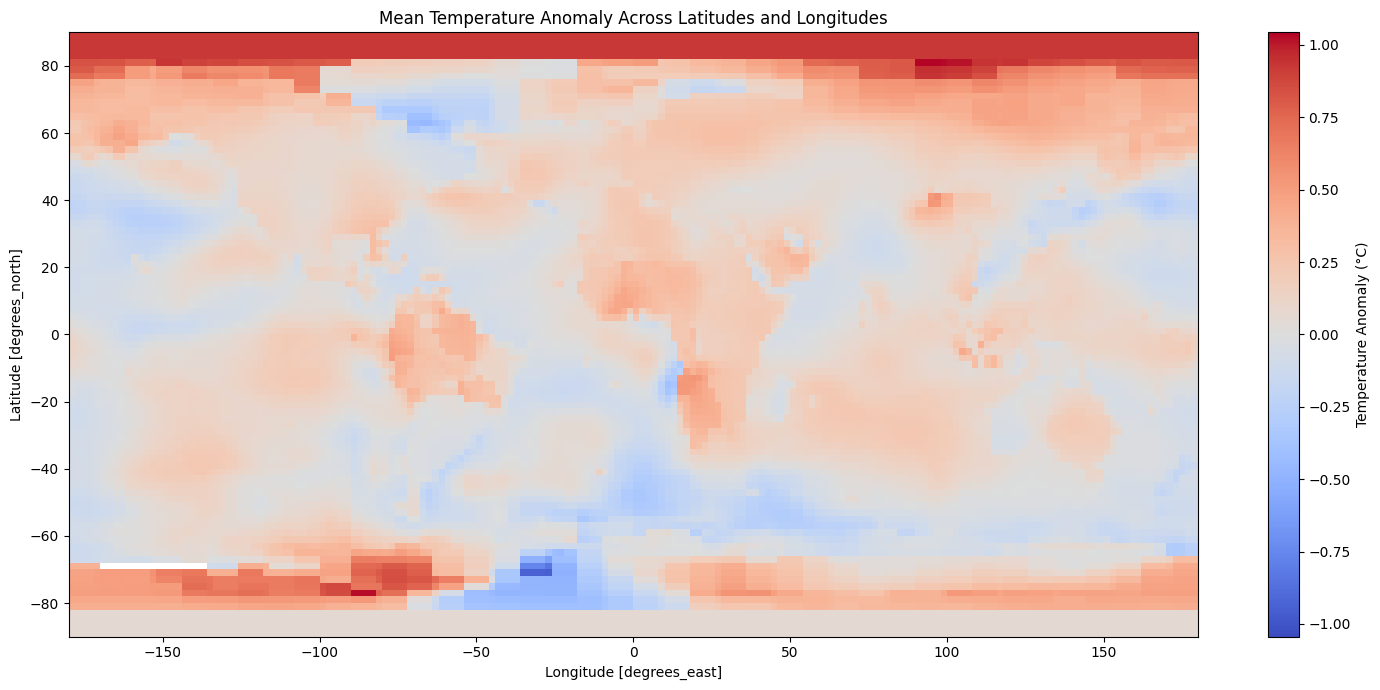

In [2]:
ds = xr.open_dataset("raw_data/gistemp1200_GHCNv4_ERSSTv5.nc")

# Extracting latitude, longitude and the mean temperature anomaly across time
lats = ds["lat"].values
lons = ds["lon"].values
tempanomaly = ds["tempanomaly"]
mean_tempanomaly = tempanomaly.mean(dim="time")

# 2D visualization
plt.figure(figsize=(15, 7))
mean_tempanomaly.plot(cmap='coolwarm', cbar_kwargs={'label': 'Temperature Anomaly (°C)'})
plt.title("Mean Temperature Anomaly Across Latitudes and Longitudes")
plt.tight_layout()
plt.show()

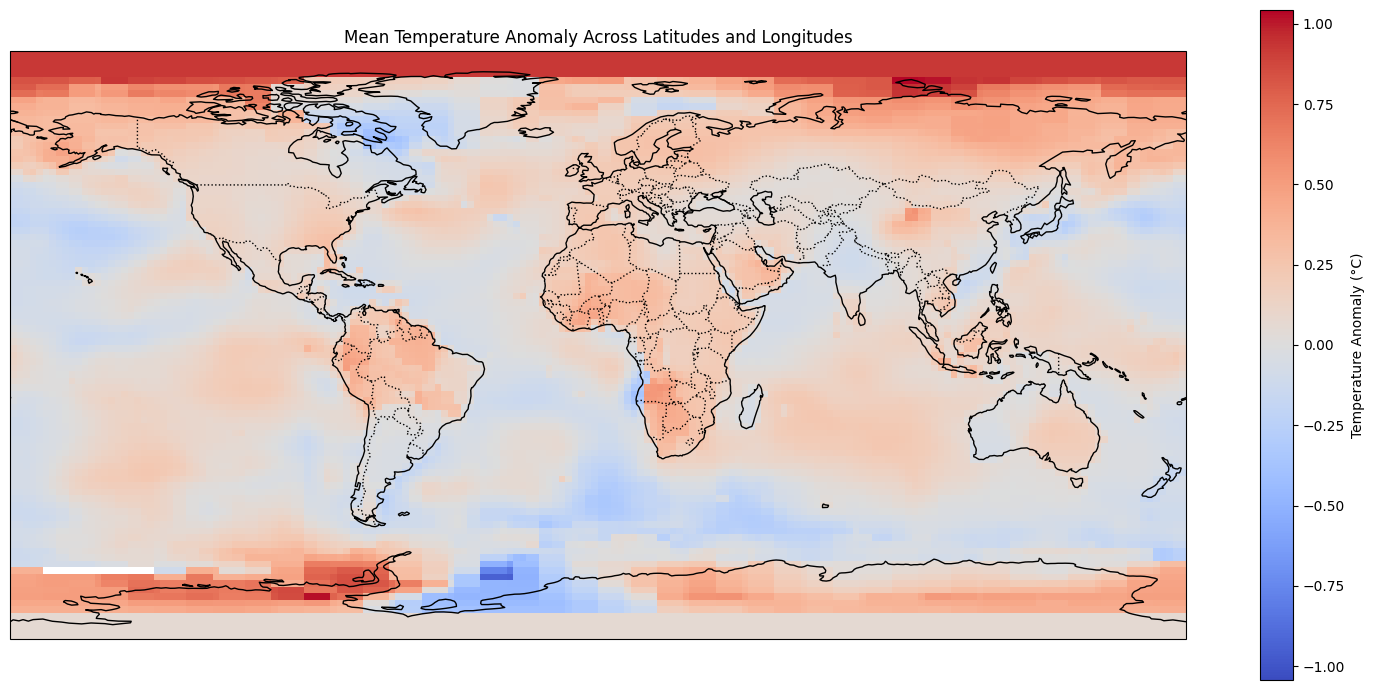

In [3]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(15, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the mean temperature anomaly on the map
mean_tempanomaly.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', 
                      cbar_kwargs={'label': 'Temperature Anomaly (°C)'})
ax.set_global()
ax.set_title("Mean Temperature Anomaly Across Latitudes and Longitudes")

plt.tight_layout()
plt.show()

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Calculate the baseline average for 1951-1980
baseline_period = tempanomaly.sel(time=slice('1951', '1980')).mean(dim='time')
# Estimate the actual global temperatures by adding the anomalies to the baseline average
estimated_temps = tempanomaly + baseline_period

def plot_time_slice(time_index):
    plt.figure(figsize=(15, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    estimated_temps.isel(time=time_index).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                               cmap='coolwarm', cbar_kwargs={'label': 'Estimated Temperature (°C)'})
    
    plt.title(f"Estimated Temperature for {str(estimated_temps['time'].isel(time=time_index).values)[:10]}")
    plt.tight_layout()
    plt.show()

# Create interactive widget
widgets.interactive(plot_time_slice, time_index=widgets.IntSlider(min=0, max=len(estimated_temps['time'])-1, step=1, value=0))




interactive(children=(IntSlider(value=0, description='time_index', max=1722), Output()), _dom_classes=('widget…

In [5]:
tempanomaly.sel(time=slice('1951', '1980'))

<xarray.DataArray 'tempanomaly' (time: 360, lat: 90, lon: 180)>
array([[[  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [-4.02, -4.02, ..., -4.02, -4.02],
        [-4.02, -4.02, ..., -4.02, -4.02]],

       [[  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [ 0.13,  0.13, ...,  0.13,  0.13],
        [ 0.13,  0.13, ...,  0.13,  0.13]],

       ...,

       [[ 4.62,  4.62, ...,  4.62,  4.62],
        [ 4.62,  4.62, ...,  4.62,  4.62],
        ...,
        [-4.94, -4.94, ..., -4.94, -4.94],
        [-4.94, -4.94, ..., -4.94, -4.94]],

       [[ 2.63,  2.63, ...,  2.63,  2.63],
        [ 2.63,  2.63, ...,  2.63,  2.63],
        ...,
        [-2.12, -2.12, ..., -2.12, -2.12],
        [-2.12, -2.12, ..., -2.12, -2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 1951-01-15 1951-02-15 ... 1980-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

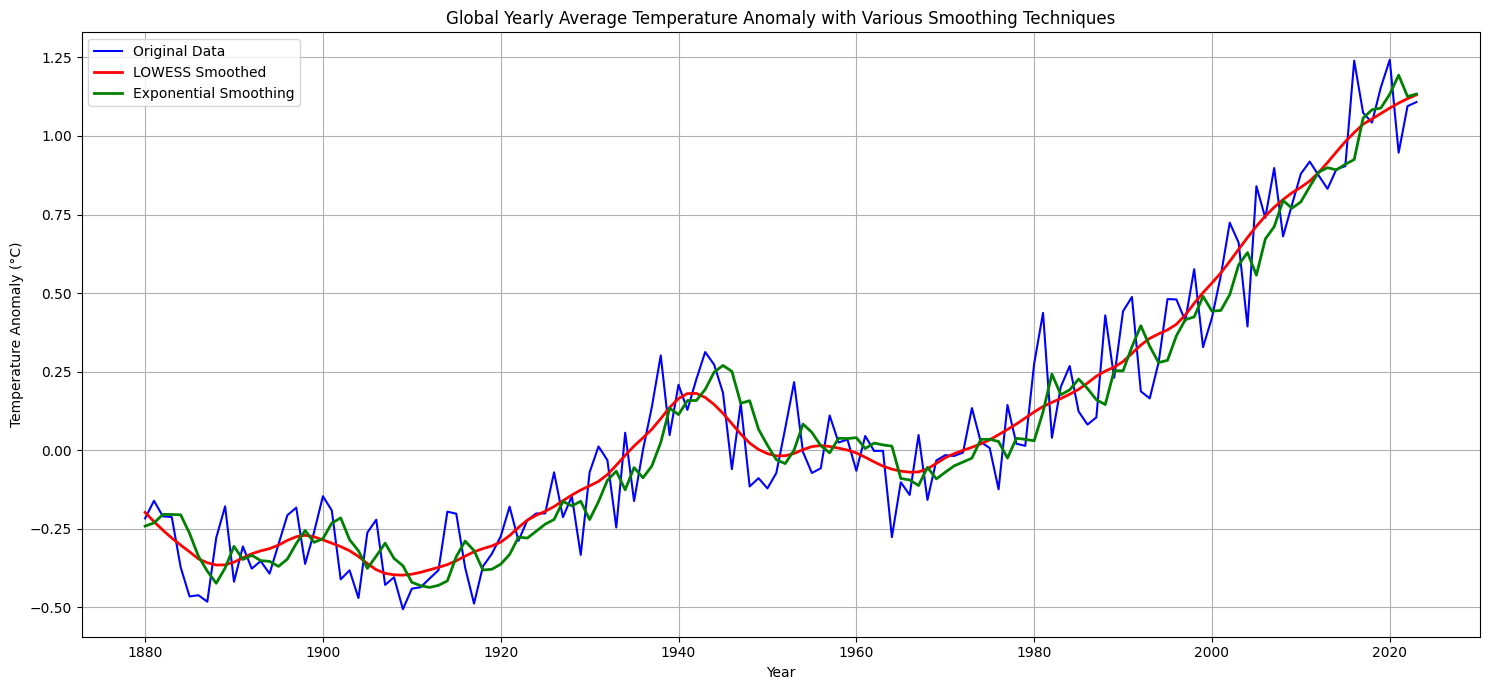

In [6]:

# Calculate the yearly average temperature anomaly
yearly_average = tempanomaly.resample(time='1Y').mean(dim='time')
global_yearly_average = yearly_average.mean(dim=["lat", "lon"]).values

# Ensure the data is one-dimensional
years = np.array([pd.to_datetime(date).year for date in yearly_average['time'].values])
global_yearly_average = np.squeeze(global_yearly_average)

# Perform LOWESS smoothing
smoothed = lowess(global_yearly_average, years, frac=0.1)

# Exponential Smoothing
model = ExponentialSmoothing(global_yearly_average, trend="additive")
model_fit = model.fit()
yhat = model_fit.predict(start=0, end=len(global_yearly_average)-1)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(years, global_yearly_average, label="Original Data", color='blue')
plt.plot(years, smoothed[:, 1], label="LOWESS Smoothed", color='red', linewidth=2)
plt.plot(years, yhat, label="Exponential Smoothing", color='green', linewidth=2)
plt.title("Global Yearly Average Temperature Anomaly with Various Smoothing Techniques")
plt.ylabel("Temperature Anomaly (°C)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
global_yearly_average

array([-2.16793969e-01, -1.60836607e-01, -2.10305318e-01, -2.12619960e-01,
       -3.72163355e-01, -4.65233982e-01, -4.61271971e-01, -4.81930077e-01,
       -2.78728694e-01, -1.78507164e-01, -4.18459594e-01, -3.06205750e-01,
       -3.76719058e-01, -3.52716595e-01, -3.92456889e-01, -2.99929678e-01,
       -2.07020834e-01, -1.82531923e-01, -3.61657768e-01, -2.61332572e-01,
       -1.46324918e-01, -1.91662118e-01, -4.10911471e-01, -3.82047176e-01,
       -4.70320463e-01, -2.62012303e-01, -2.21036524e-01, -4.28414017e-01,
       -4.04166698e-01, -5.05937278e-01, -4.40540075e-01, -4.35646743e-01,
       -4.08253908e-01, -3.81672472e-01, -1.95514202e-01, -2.01835960e-01,
       -3.73592764e-01, -4.88072813e-01, -3.69547725e-01, -3.29643428e-01,
       -2.74144977e-01, -1.79535478e-01, -2.88286150e-01, -2.22075909e-01,
       -2.01179475e-01, -2.01006100e-01, -7.01971874e-02, -2.12952748e-01,
       -1.46746323e-01, -3.33013028e-01, -7.01670200e-02,  1.20676551e-02,
       -3.17363590e-02, -